### Loading Libraries 

In [159]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,recall_score,roc_curve, roc_auc_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import matplotlib.pyplot as plt


### Reading Data

In [160]:
recipe_data = pd.read_csv('recipe_site_traffic_2212.csv')

In [161]:
recipe_data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [162]:
print(recipe_data.columns)
print('Shape of Data: ',recipe_data.shape)

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic'],
      dtype='object')
Shape of Data:  (947, 8)


In [163]:
recipe_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [164]:
recipe_data.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

### EDA : NA values pattern visualization

<Axes: >

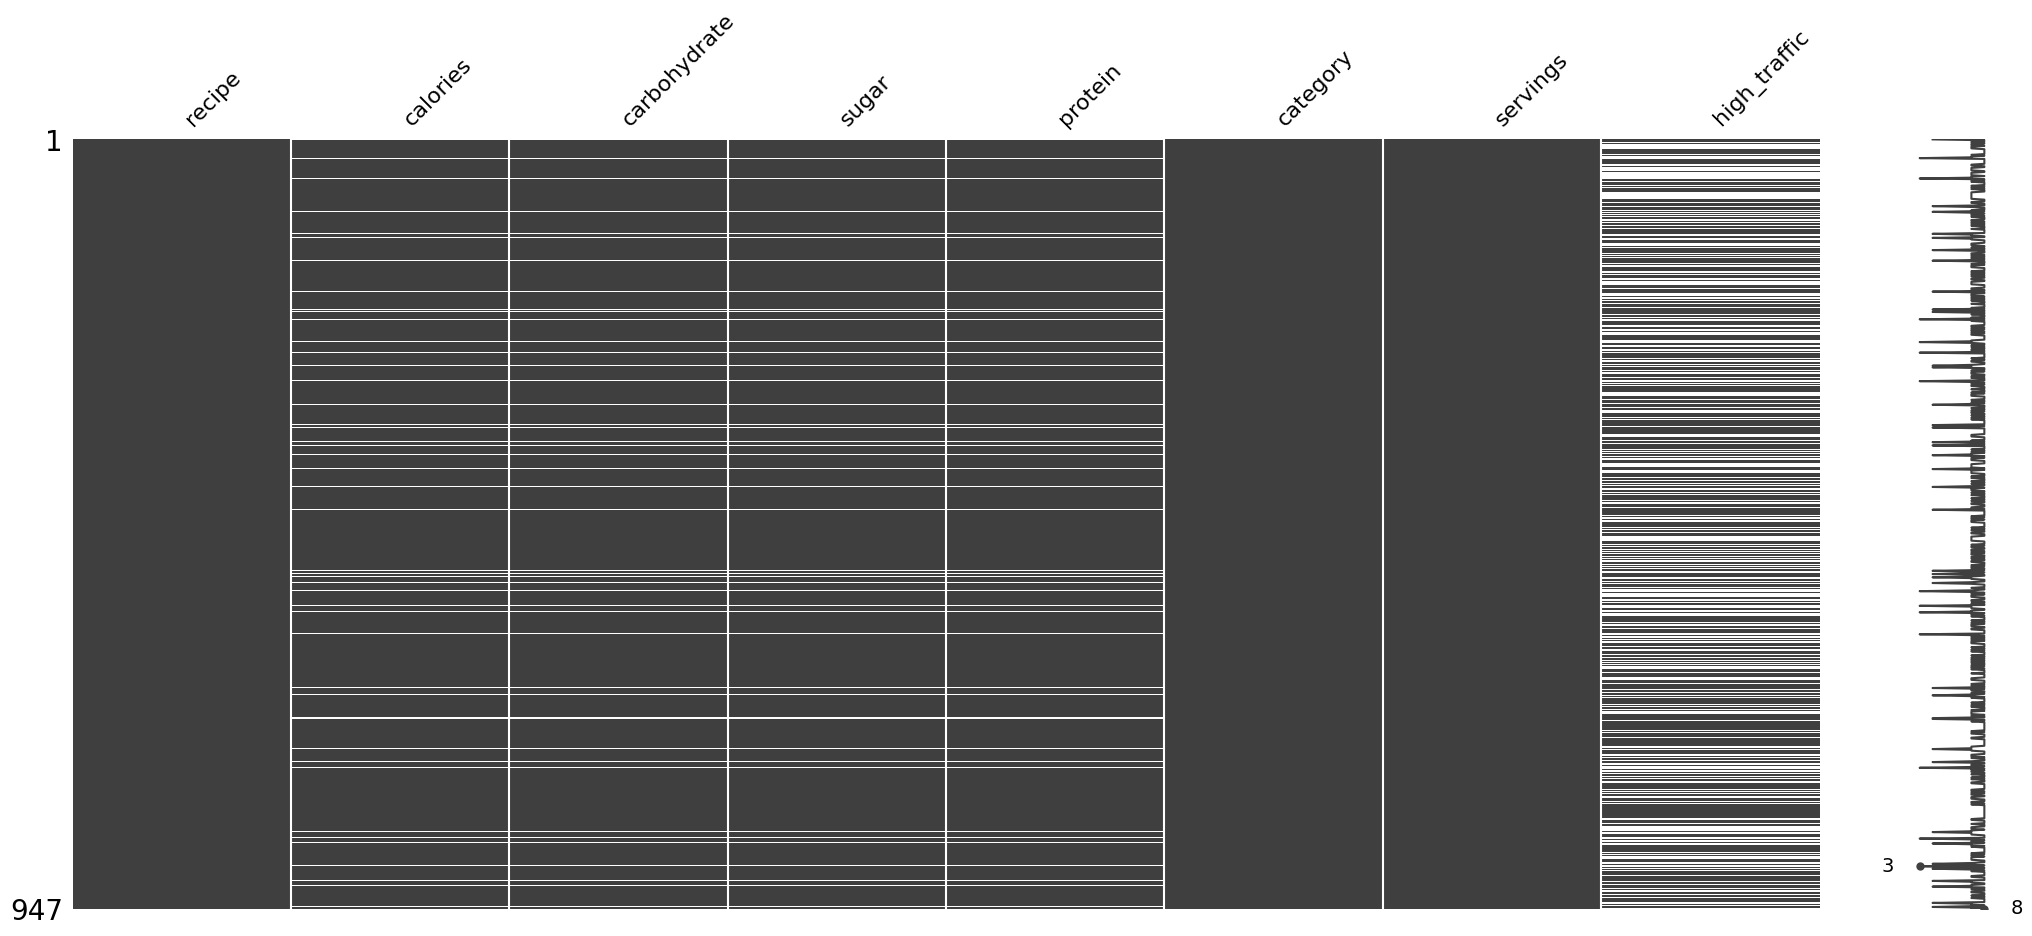

In [165]:
#visualizing Sparsity pattern of missing values in df.
msno.matrix(recipe_data)
#looking at the data we can identify the pattern that 'calories', 'carbohydrate', 'sugar', 'protein' has missing vaues in a same row. High Traffic missing values consider as low.

<Axes: >

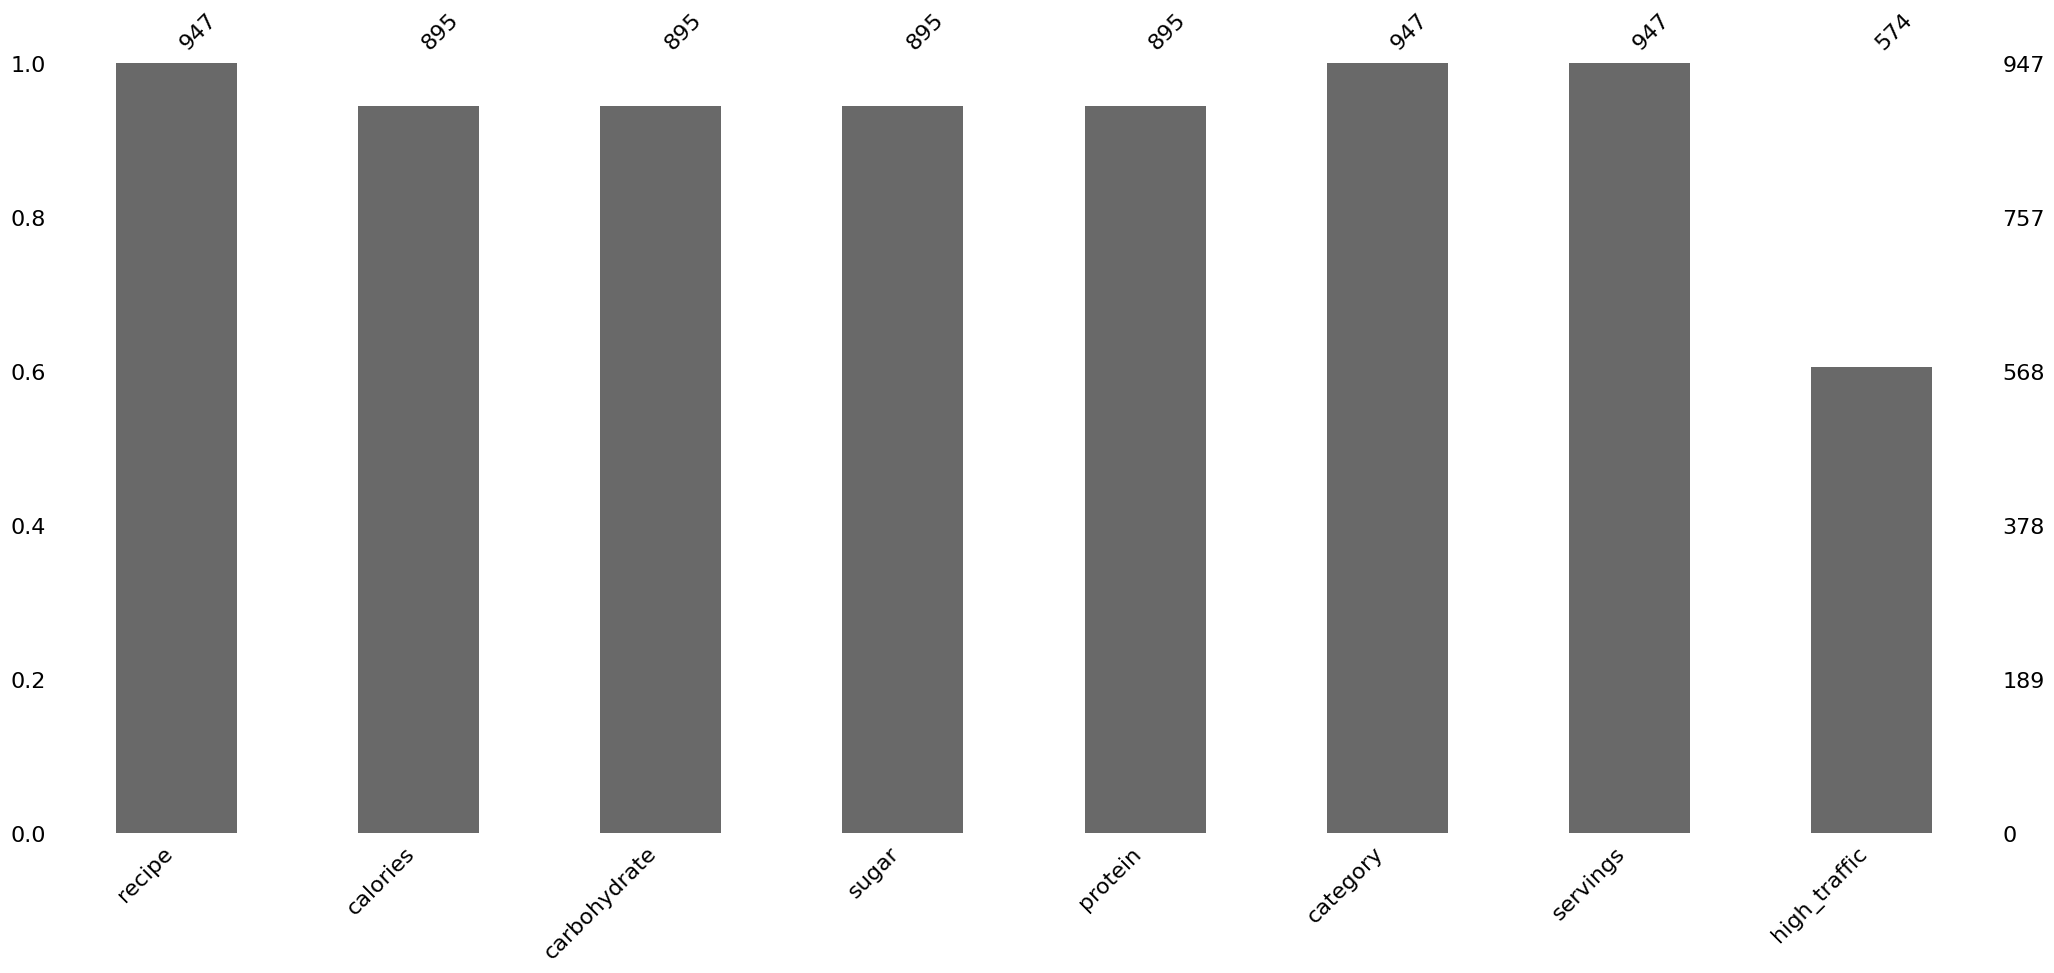

In [166]:
#visualizing the number of non missing values in each feature.Whic confirms that 'calories', 'carbohydrate', 'sugar', 'protein' 
# has the 5% missing values in a pattern.
msno.bar(recipe_data)

Upon examining the dataset,I identified a specific pattern where the features 'calories', 'carbohydrate', 'sugar', and 'protein' all have missing values in the same rows. To better understand this pattern, we can see this pattern msno matrix visualization.

Bargraph visualization confirmed that 'calories', 'carbohydrate', 'sugar', and 'protein' have about 5% missing values, which occurring in the same rows. Additionaly,I tried imputation methods using SimpleImputer using strategy as mean and median which has decreased the model's performance due to the high variance and standard deviations in the data.Given this ,I decided to remove these rows to maintain the integrity of our dataset. 

Finally,'high_traffic' feature, I considered missing values as "low" traffic.

After cleaning we have 895 oberservation and 8 columns.

### Removing Not Available values in data frame

In [167]:
recipe_data_clean = recipe_data.dropna(subset = ['calories', 'carbohydrate', 'sugar', 'protein'], thresh = 4 )
recipe_data_clean.shape

#recipe_data_clean = recipe_data
#impute_na = SimpleImputer(strategy='median')
#recipe_data_clean[['calories', 'carbohydrate', 'sugar', 'protein']] = impute_na.fit_transform(recipe_data[['calories', 'carbohydrate', 'sugar', 'protein']])

(895, 8)

In [168]:
recipe_data_clean = recipe_data_clean.fillna('Low')

In [169]:
#Rechecking the NA values after cleaning the data
recipe_data_clean.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [170]:
recipe_data_clean

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken Breast,4,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,Low
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [171]:
recipe_data_clean['high_traffic'].value_counts(normalize = True)

high_traffic
High    0.597765
Low     0.402235
Name: proportion, dtype: float64

In [172]:
#Analyzing servings feature
recipe_data_clean['servings'].value_counts()

servings
4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

cleanning servings feature and dtype changing to int

In [173]:
recipe_data_clean['servings'] = recipe_data_clean['servings'].str.replace('as a snack','').astype('int64')
recipe_data_clean['servings'].value_counts()


servings
4    367
6    185
2    174
1    169
Name: count, dtype: int64

Cleaning categories as per identified categories Lunch/Snacks', 'Beverages', 'Potato','Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'

In [174]:
#identified categories Lunch/Snacks', 'Beverages', 'Potato','Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'
recipe_data_clean['category'].value_counts()

category
Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: count, dtype: int64

In [175]:
#grouping Chicken Breast and Chicken together
recipe_data_clean.loc[recipe_data_clean['category'] == 'Chicken Breast','category'] = 'Chicken'
recipe_data_clean['category'] = recipe_data_clean['category'].astype('category')
recipe_data_clean['category'].value_counts()

category
Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: count, dtype: int64

Summary:

The data contains 947 entries with the following columns:

recipe: Numeric(int64), unique identifier of the recipe

calories: Numeric(float64),This column having 52 missing values.
carbohydrate: Numeric(float64),This column having 52 missing values.
sugar:  Numeric(float64),This column having 52 missing values.
protein:  Numeric(float64),This column having 52 missing values.

Upon examining the dataset,I identified a specific pattern where the features 'calories', 'carbohydrate', 'sugar', and 'protein' all have missing values in the same rows. Bargraph visualization confirmed that 'calories', 'carbohydrate', 'sugar', and 'protein' have about 5% missing values, which occurring in the same rows. Given this ,I decided to remove these rows to maintain the integrity of our dataset. 

category: I identified some non-standard categories in the "Category" column, which was of type object. For instance, I found a category named 'chicken breast' that wasn't part of the standardized categories. To address this, I combined 'chicken breast' with the 'Chicken' category.
After these adjustments, the final categories in this column are Lunch/Snacks,Beverages,Potato,Vegetable,Meat,Chicken,Pork,Dessert,Breakfast
One Dish Meal.Finally, I changed the column type to 'category'.

servings: I identified some characters in the numerical columns, specifically 'as a snack' mixed with numerical values in the 'servings' column. I removed these non-numeric entries and converted the column data type to int64.

high_traffic: object, indicates high traffic ("High") and 373 missing values.I have replace all the missing values with low traffic("Low")

After cleaning the data set contains 895 obervations.

In [176]:
recipe_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int64   
 7   high_traffic  895 non-null    object  
dtypes: category(1), float64(4), int64(2), object(1)
memory usage: 57.2+ KB


In [177]:
recipe_data_clean.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [178]:
recipe_data_clean.head(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken,4,Low
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,Low
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,Low
10,11,170.12,17.63,4.10,0.91,Beverages,1,Low


## EDA

We can notice that features are having higher standard deviations and different scaling.

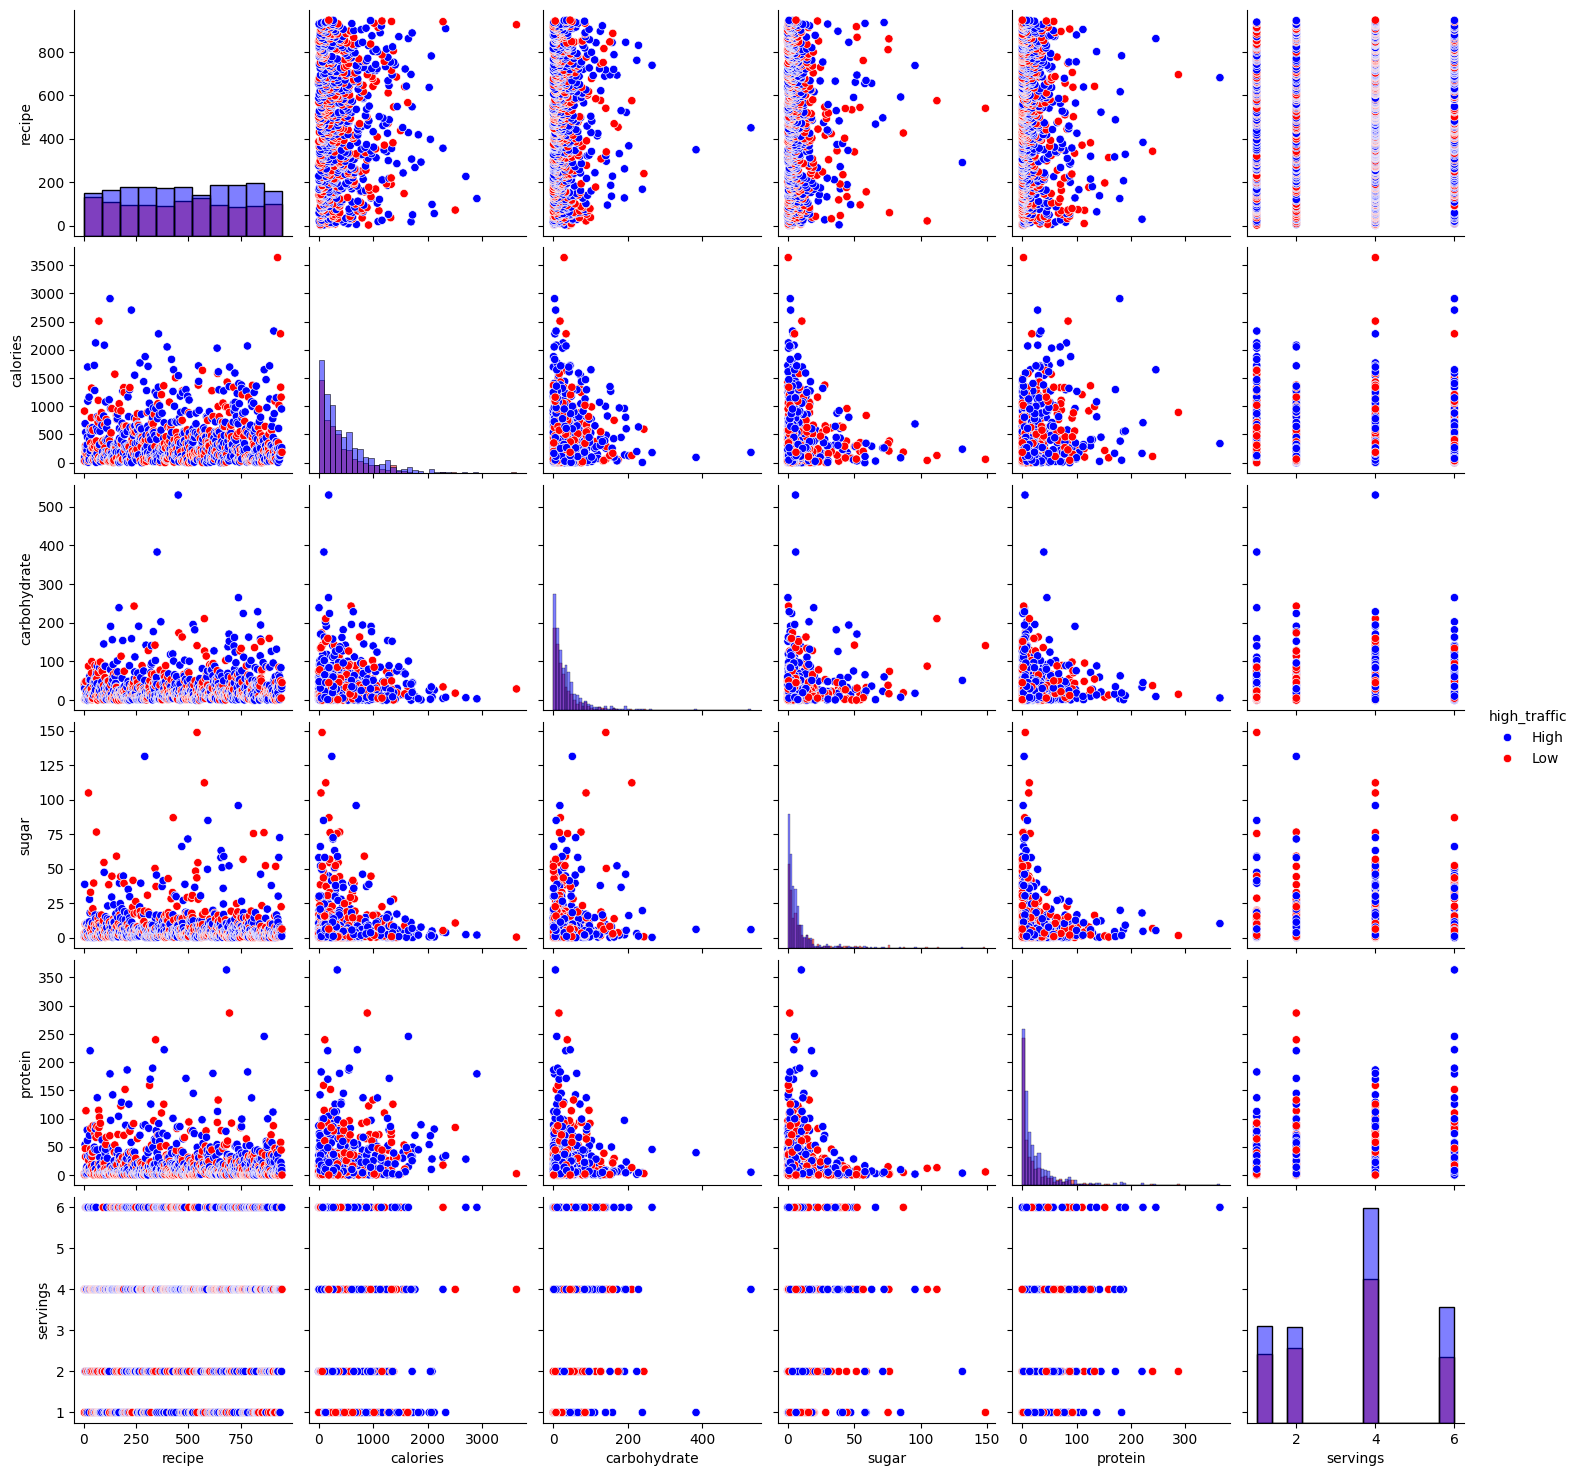

In [179]:
#viszualising multicollinearity between variables
custom_palette = {'High': 'blue', 'Low': 'red'}
sns.pairplot(recipe_data_clean,hue = 'high_traffic',palette=custom_palette,diag_kind= 'hist')

Before proceeding with feature scaling, it is important to check for multicollinearity among the numerical features. High multicollinearity can negatively impact the performance of certain models, such as Logistic Regression. We visualized the correlation matrix to check for multicollinearity.

We can notice that there is no strong relationship between the features, which confirms no multicollinearity. This is ideal for models like Logistic Regression and KNN, which can be sensitive to multicollinearity.

### Correlation between Features

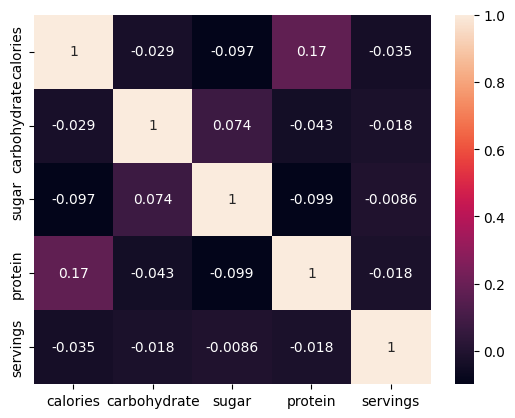

In [180]:
#shows very week relationsip between variable which ensures non-multicollinearity between features 
correlation = recipe_data_clean[['calories', 'carbohydrate', 'sugar', 'protein','servings']].corr()
sns.heatmap(correlation,annot = True)
plt.show()

This correlation matrix also confirms there no strong relationship between features.The highest correlation we could see as 0.17.

### Histogram of Numerical Features

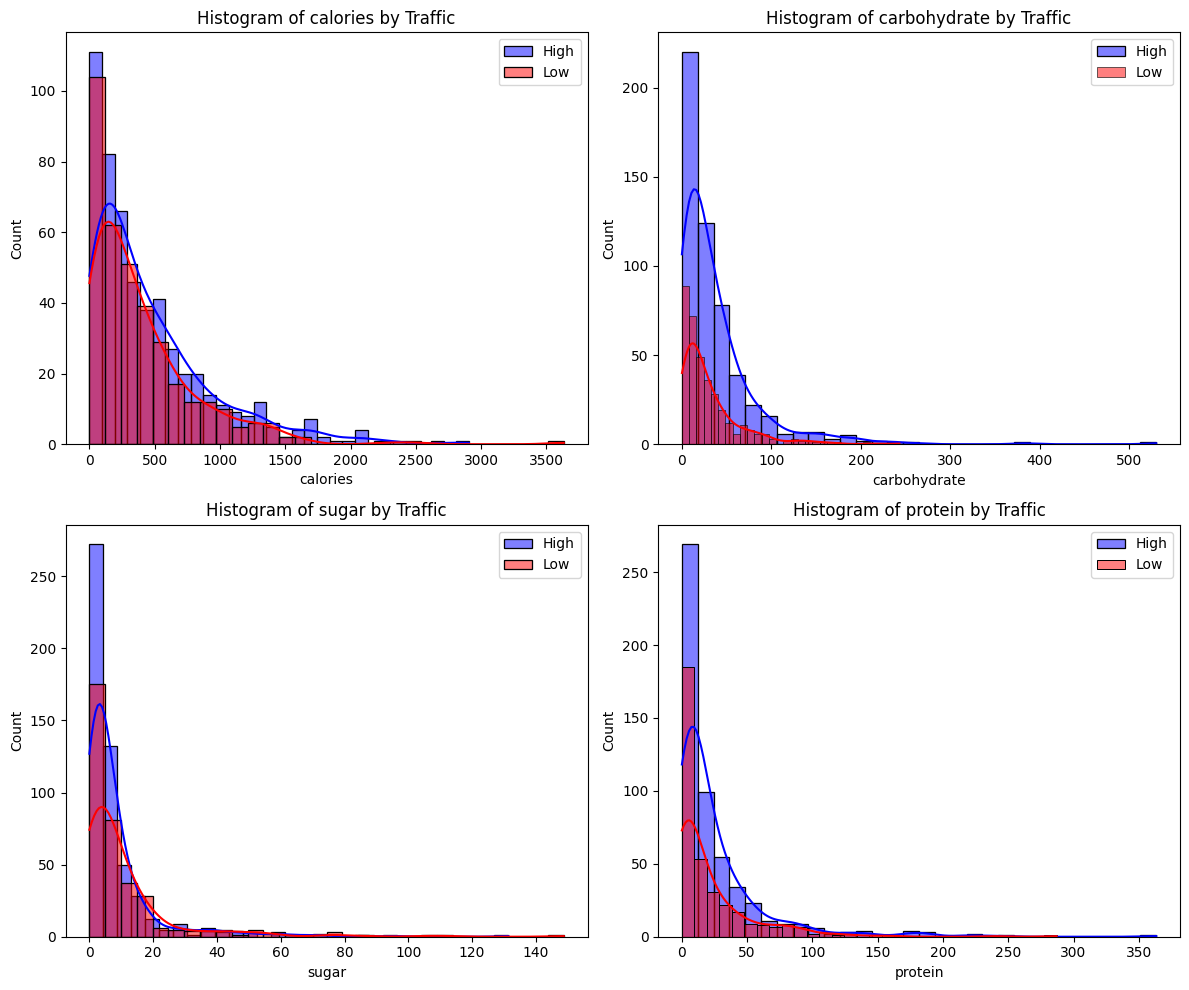

In [181]:
# Assuming recipe_data_clean is your DataFrame and numeric_fea is your list of numeric features
numeric_fea = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(numeric_fea):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    # Plot histograms for 'High' and 'Low' traffic recipes
    sns.histplot(recipe_data_clean[recipe_data_clean['high_traffic'] == 'High'][feature], bins=30, color='blue', label='High', alpha=0.5,kde = True, ax=ax[row, col])
    sns.histplot(recipe_data_clean[recipe_data_clean['high_traffic'] == 'Low'][feature], bins=30, color='red', label='Low', alpha=0.5,kde = True, ax=ax[row, col])
    
    # Set plot title and labels
    ax[row, col].set_title(f'Histogram of {feature} by Traffic')
    ax[row, col].set_xlabel(feature)
    ax[row, col].set_ylabel('Count')
    ax[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


The numerical features 'calories', 'carbohydrate', 'sugar', and 'protein' are heavily left-skewed. To address this skewness and ensure proper scaling for our machine learning models, we need to standardize the features.

### Violin Plot

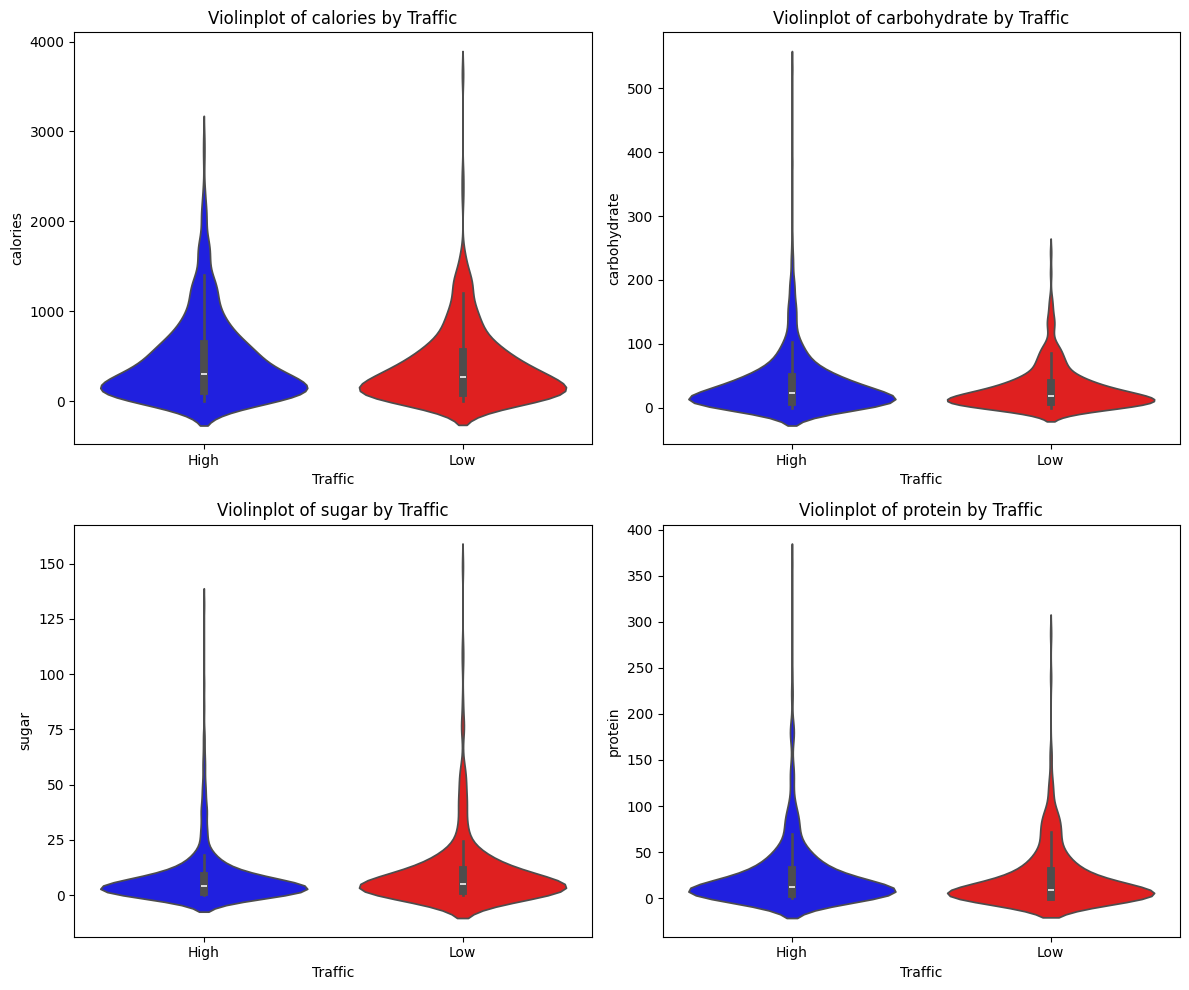

In [182]:
#violinplot
custom_palette = {'High': 'blue', 'Low': 'red'}
numeric_fea = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(numeric_fea):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    sns.violinplot(data = recipe_data_clean, x = 'high_traffic',y = feature,hue='high_traffic',palette=custom_palette,ax = ax[row,col])    
    # Set plot title and labels
    ax[row, col].set_title(f'Violinplot of {feature} by Traffic')
    ax[row, col].set_xlabel('Traffic')
    ax[row, col].set_ylabel(feature)
    #ax[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()



Additionally, a violin plot confirms the left-skewed distribution and different scales of the numerical features, further justifying the need for standardization.

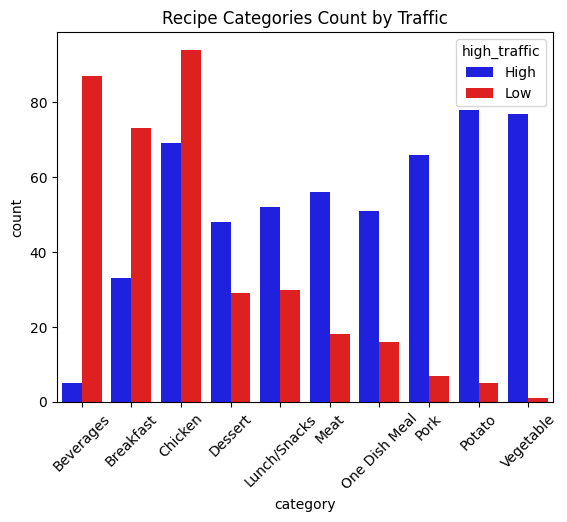

In [183]:
custom_palette = {'High': 'blue', 'Low': 'red'}
sns.countplot(x = 'category', hue = 'high_traffic',palette=custom_palette,data = recipe_data_clean)
plt.title('Recipe Categories Count by Traffic')
plt.xticks(rotation=45) 
plt.show()

In [184]:

# Assuming 'recipe_data_clean' is your dataframe

# Group by 'category' and 'high_traffic' and count the occurrences
perc = recipe_data_clean.groupby(['category', 'high_traffic'])['high_traffic'].count().reset_index(name='count')

# Get the total counts for each category
total_counts = recipe_data_clean['category'].value_counts().reset_index()
total_counts.columns = ['category', 'total_count']

# Merge the percentage counts with the total counts
merged = perc.merge(total_counts, how='left', on='category')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Sort values for better readability
merged = merged.sort_values(by=['category', 'high_traffic'])

print(merged)


         category high_traffic  count  total_count  percentage
0       Beverages         High      5           92    5.434783
1       Beverages          Low     87           92   94.565217
2       Breakfast         High     33          106   31.132075
3       Breakfast          Low     73          106   68.867925
4         Chicken         High     69          163   42.331288
5         Chicken          Low     94          163   57.668712
6         Dessert         High     48           77   62.337662
7         Dessert          Low     29           77   37.662338
8    Lunch/Snacks         High     52           82   63.414634
9    Lunch/Snacks          Low     30           82   36.585366
10           Meat         High     56           74   75.675676
11           Meat          Low     18           74   24.324324
12  One Dish Meal         High     51           67   76.119403
13  One Dish Meal          Low     16           67   23.880597
14           Pork         High     66           73   90

C:\Users\Karthi\AppData\Local\Temp\ipykernel_12572\2574733071.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perc = recipe_data_clean.groupby(['category', 'high_traffic'])['high_traffic'].count().reset_index(name='count')


Potato,Vegetable,Pork, Shown high traffic more than 90% percent of the time when it has featured in the web site.


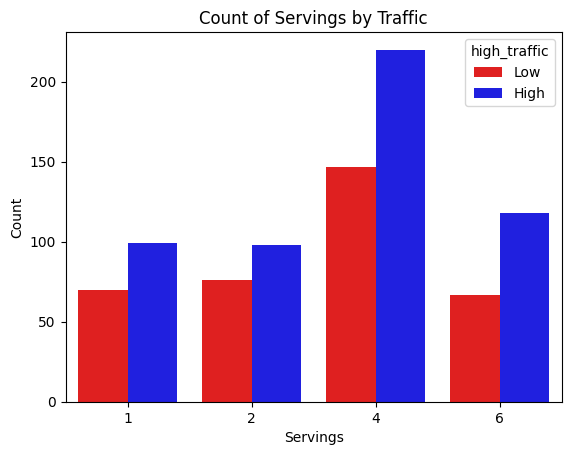

In [185]:
sns.countplot(data = recipe_data_clean,x = 'servings',hue = 'high_traffic' , palette=custom_palette)
plt.xlabel('Servings')
plt.ylabel('Count')
plt.title('Count of Servings by Traffic')
plt.show()

Number of Servings as 4 being common in both Low and high traffic types.  

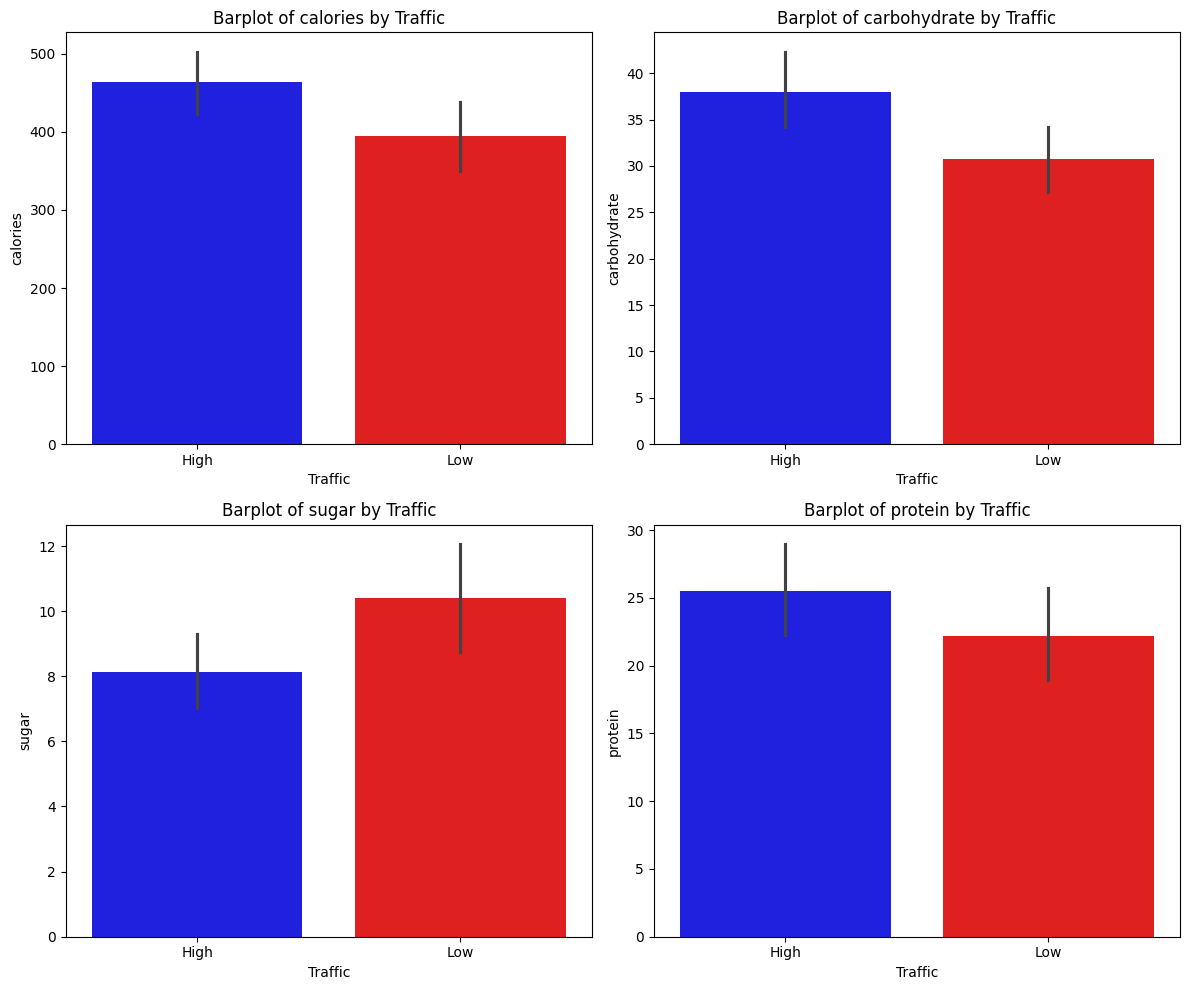

In [186]:


numeric_fea = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(numeric_fea):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    sns.barplot(data = recipe_data_clean, x = 'high_traffic',y = feature,hue='high_traffic',palette=custom_palette,ax = ax[row,col])   
    # Set plot title and labels
    ax[row, col].set_title(f'Barplot of {feature} by Traffic')
    ax[row, col].set_xlabel('Traffic')
    ax[row, col].set_ylabel(feature)
    #ax[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

Visualized the mean values of our numerical features for both high and low traffic recipes using a bar graph. The standard deviation bars depict high variance in the numerical features, which confirms the need for feature scaling.

### Classification Count

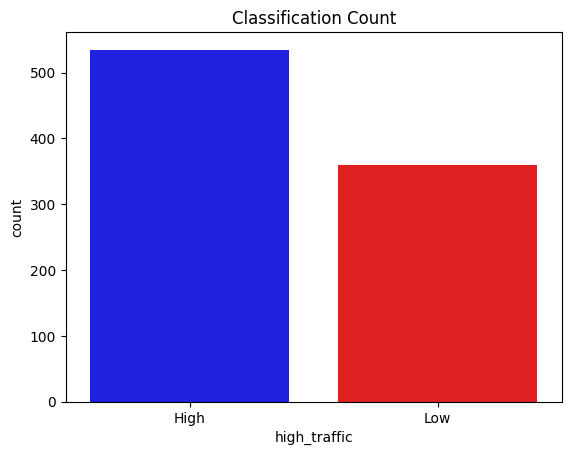

In [187]:
sns.countplot(data = recipe_data_clean,x = 'high_traffic',hue = 'high_traffic',palette= custom_palette)
plt.title('Classification Count')
plt.show()

High traffic data points are 535(60%) and low Traffic data points are 360(40%) as shown  in classification countplot.There is some imbalance in the class,so I decided go by stratified sampling while spliting the data set.

In [188]:
recipe_data_clean['high_traffic'].value_counts(normalize=True)

high_traffic
High    0.597765
Low     0.402235
Name: proportion, dtype: float64

### Box Plot

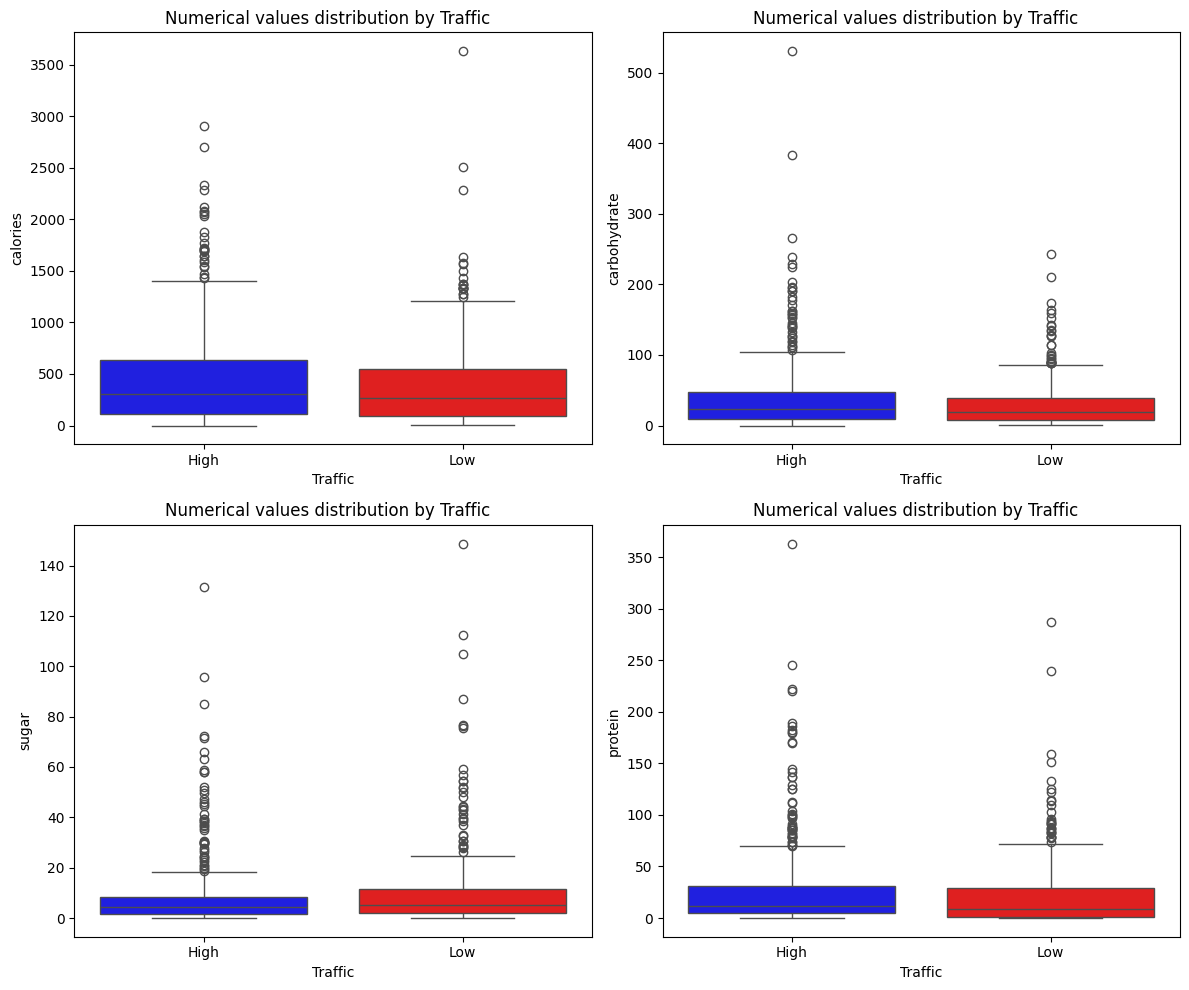

In [189]:
# Assuming recipe_data_clean is your DataFrame and numeric_fea is your list of numeric features
numeric_fea = ['calories', 'carbohydrate', 'sugar', 'protein']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
#custom_palette = {'High': 'blue', 'Low': 'red'}


# Loop through each feature and plot histograms
for i, feature in enumerate(numeric_fea):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    # Plot histograms for 'High' and 'Low' traffic recipes
    sns.boxplot(data = recipe_data_clean, x ='high_traffic' , y = feature ,hue = 'high_traffic',palette=custom_palette, ax = ax[row,col])
    
    # Set plot title and labels
    ax[row, col].set_title('Numerical values distribution by Traffic  ')
    ax[row, col].set_xlabel('Traffic')
    ax[row, col].set_ylabel(feature)
    #ax[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


Box plot shows numerical value distributions we can able to see that values are spread on upper limit.Here we can see outliers in the upper limit.

### Outliers

In [190]:
def outliers(data):
    lower = np.quantile(data,0.25)
    upper = np.quantile(data,0.75)
    irq = upper - lower
    lower_limit = lower - (1.5*irq)
    upper_limit = upper + (1.5*irq)
    return lower_limit,upper_limit
for column in ['calories', 'carbohydrate', 'sugar', 'protein']:
    lower_limit,upper_limit = outliers(recipe_data_clean[column])
    print( column + ' Lower Limit: ',lower_limit )
    print( column + ' Upper Limit: ',upper_limit )
    print(column+' Number of data points:',len(recipe_data_clean[(recipe_data_clean[column] < lower_limit) | (recipe_data_clean[column] > upper_limit )]))
    

calories Lower Limit:  -620.3999999999999
calories Upper Limit:  1328.48
calories Number of data points: 47
carbohydrate Lower Limit:  -46.510000000000005
carbohydrate Upper Limit:  99.85000000000001
carbohydrate Number of data points: 58
sugar Lower Limit:  -10.475000000000003
sugar Upper Limit:  21.965000000000003
sugar Number of data points: 79
protein Lower Limit:  -37.31250000000001
protein Upper Limit:  70.70750000000001
protein Number of data points: 77


Numerical data is available in different scale ,so if we remove the outliers it will led to significant data loss.So its decided to standardize the numerical features.

### Preprocessing

#### Encoding Target Variable

In [191]:
#Encoding Target Variable
recipe_data_clean['high_traffic_encoded'] = recipe_data_clean['high_traffic'].apply(lambda x : 1 if x == 'High'else 0 )

#### Encoding Category Features

In [192]:
#onehotencoding for category variables.
recipe_data_clean = pd.get_dummies(data = recipe_data_clean , columns = ['category'])

In [193]:
recipe_data_clean

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,high_traffic_encoded,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
1,2,35.48,38.56,0.66,0.92,4,High,1,False,False,False,False,False,False,False,False,True,False
2,3,914.28,42.68,3.09,2.88,1,Low,0,False,True,False,False,False,False,False,False,False,False
3,4,97.03,30.56,38.63,0.02,4,High,1,True,False,False,False,False,False,False,False,False,False
4,5,27.05,1.85,0.80,0.53,4,Low,0,True,False,False,False,False,False,False,False,False,False
5,6,691.15,3.46,1.65,53.93,2,High,1,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,High,1,False,False,True,False,False,False,False,False,False,False
942,943,1161.00,5.31,22.39,44.22,2,Low,0,False,False,False,False,True,False,False,False,False,False
944,945,951.74,29.42,3.57,13.87,2,High,1,False,False,False,False,False,False,False,True,False,False
945,946,266.61,35.77,0.97,8.07,6,High,1,False,False,False,False,False,False,False,False,True,False


In [194]:
recipe_data_clean.columns

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'servings',
       'high_traffic', 'high_traffic_encoded', 'category_Beverages',
       'category_Breakfast', 'category_Chicken', 'category_Dessert',
       'category_Lunch/Snacks', 'category_Meat', 'category_One Dish Meal',
       'category_Pork', 'category_Potato', 'category_Vegetable'],
      dtype='object')

In [195]:
recipe_model = recipe_data_clean[['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category_Beverages',
       'category_Breakfast', 'category_Chicken', 'category_Dessert',
       'category_Lunch/Snacks', 'category_Meat', 'category_One Dish Meal',
       'category_Pork', 'category_Potato', 'category_Vegetable','high_traffic_encoded']]

In [196]:
recipe_model.describe()

,calories,carbohydrate,sugar,protein,servings,high_traffic_encoded
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,3.458101,0.597765
std,453.020997,43.949032,14.679176,36.369739,1.735979,0.490623
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,110.430000,8.375000,1.690000,3.195000,2.000000,0.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,597.650000,44.965000,9.800000,30.200000,4.000000,1.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


#### Train/Test Split

In [197]:
X = recipe_model.drop(columns='high_traffic_encoded')
y = recipe_model[['high_traffic_encoded']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify= y,random_state= 2024)

In [198]:
X_train

,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
548,1440.69,30.59,5.78,30.63,6,False,False,False,False,True,False,False,False,False,False
598,296.23,8.84,5.10,0.68,6,True,False,False,False,False,False,False,False,False,False
381,1362.81,26.21,1.94,125.43,4,False,False,True,False,False,False,False,False,False,False
520,363.51,23.52,0.50,78.49,1,False,False,True,False,False,False,False,False,False,False
666,100.39,9.66,24.37,16.97,2,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,1370.80,0.48,2.15,1.65,4,False,False,False,False,False,True,False,False,False,False
13,25.23,11.51,10.32,9.57,4,False,False,False,False,False,False,False,False,False,True
679,178.95,22.59,4.04,7.04,2,False,False,False,False,False,False,True,False,False,False
930,607.52,34.88,5.49,9.79,4,False,False,False,False,True,False,False,False,False,False


### Feature scaling

I am standardizing the features using Power Transformer with yeo-johnson for numeriacl features. Since features are in different scale and left skewed I decided to use this power transform. 

In [199]:
feature_scale = PowerTransformer()
train = feature_scale.fit_transform(X_train[['calories', 'carbohydrate', 'sugar', 'protein','servings']])
test = feature_scale.transform(X_test[['calories', 'carbohydrate', 'sugar', 'protein','servings']])

In [200]:
train_num_scale = pd.DataFrame(train,columns=['calories_scaled', 'carbohydrate_scaled', 'sugar_scaled', 'protein_scaled','servings_scaled'])

### EDA after Standardization 

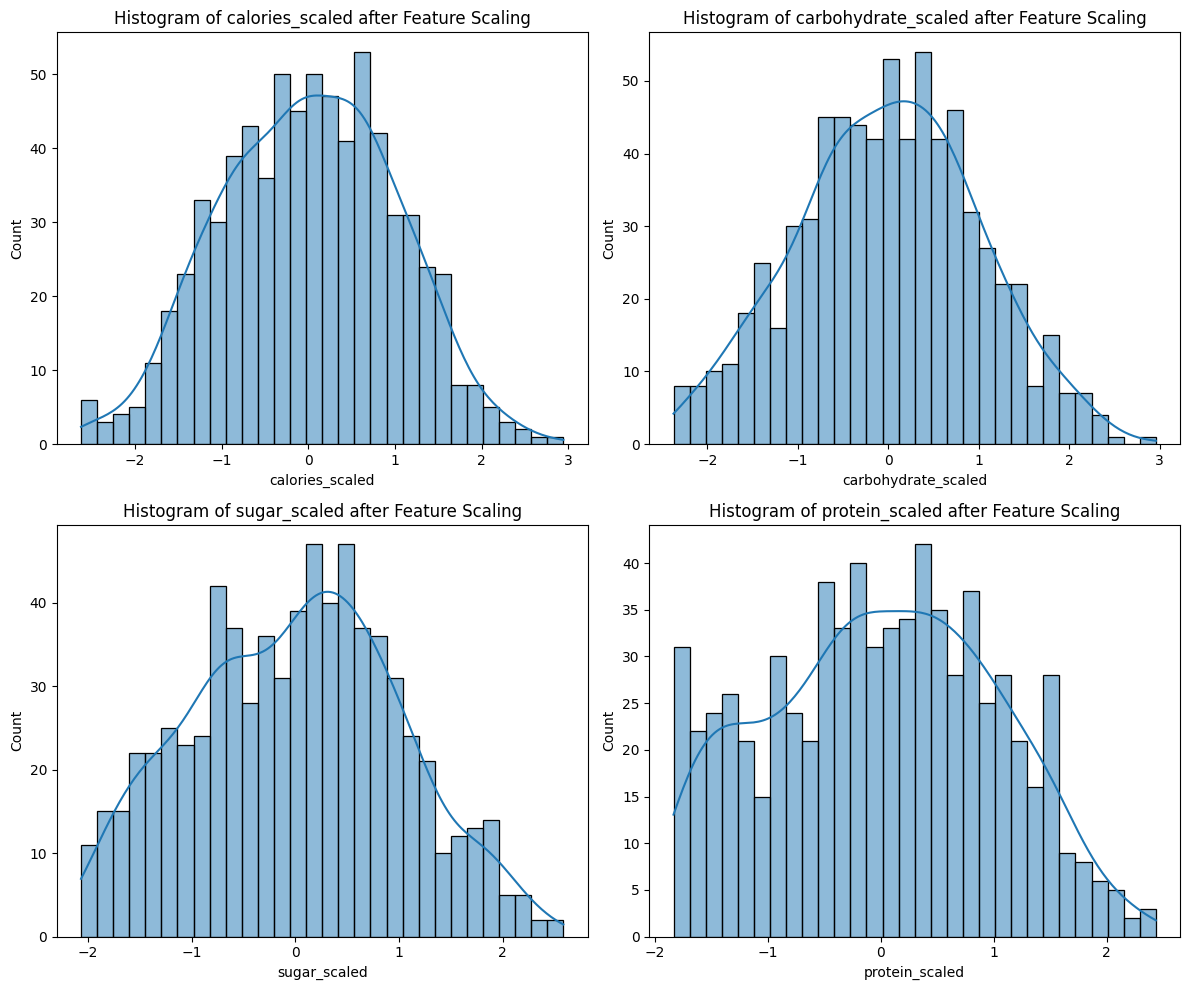

In [201]:
# Assuming recipe_data_clean is your DataFrame and numeric_fea is your list of numeric features
numeric_fea = ['calories_scaled', 'carbohydrate_scaled', 'sugar_scaled', 'protein_scaled']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each feature and plot histograms
for i, feature in enumerate(numeric_fea):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    # Plot histograms for 'High' and 'Low' traffic recipes
    sns.histplot(train_num_scale[feature], bins = 30, ax=ax[row, col],kde = True)
    # Set plot title and labels
    ax[row, col].set_title(f'Histogram of {feature} after Feature Scaling')
    ax[row, col].set_xlabel(feature)
    ax[row, col].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


After standardization, by visualising the data we can be to see that the numerical features are colse to normal distribution.

In [202]:
train_num_scale = train_num_scale.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_train_scaled = pd.concat([train_num_scale,X_train],axis = 1)
X_train_scaled = X_train_scaled.drop(columns = ['calories', 'carbohydrate', 'sugar', 'protein','servings'])
X_train_scaled = X_train_scaled[['calories_scaled','carbohydrate_scaled', 'sugar_scaled', 'protein_scaled','servings_scaled', 'category_Vegetable',
                                'category_Beverages', 'category_Breakfast','category_Chicken', 'category_Dessert', 'category_Lunch/Snacks','category_Meat', 'category_One Dish Meal', 'category_Pork','category_Potato']]

In [203]:
test_num_scale = pd.DataFrame(test,columns=['calories_scaled', 'carbohydrate_scaled', 'sugar_scaled', 'protein_scaled','servings_scaled'])
test_num_scale = test_num_scale.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_scaled = pd.concat([test_num_scale,X_test],axis = 1)
X_test_scaled = X_test_scaled.drop(columns = ['calories', 'carbohydrate', 'sugar', 'protein','servings'])
X_test_scaled = X_test_scaled[['calories_scaled','carbohydrate_scaled', 'sugar_scaled', 'protein_scaled','servings_scaled', 'category_Vegetable',
                                'category_Beverages', 'category_Breakfast','category_Chicken', 'category_Dessert', 'category_Lunch/Snacks','category_Meat', 'category_One Dish Meal', 'category_Pork','category_Potato']]

In [204]:
X_test_scaled.isna().sum()

calories_scaled           0
carbohydrate_scaled       0
sugar_scaled              0
protein_scaled            0
servings_scaled           0
category_Vegetable        0
category_Beverages        0
category_Breakfast        0
category_Chicken          0
category_Dessert          0
category_Lunch/Snacks     0
category_Meat             0
category_One Dish Meal    0
category_Pork             0
category_Potato           0
dtype: int64

In [205]:
X_train_scaled

,calories_scaled,carbohydrate_scaled,sugar_scaled,protein_scaled,servings_scaled,category_Vegetable,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato
0,1.670073,0.353440,0.269887,0.762708,1.401212,False,False,False,False,False,True,False,False,False,False
1,0.040146,-0.672985,0.162316,-1.445265,1.401212,False,True,False,False,False,False,False,False,False,False
2,1.602012,0.215890,-0.646650,1.811334,0.371770,False,False,False,True,False,False,False,False,False,False
3,0.218627,0.121067,-1.505853,1.459673,-1.482506,False,False,False,True,False,False,False,False,False,False
4,-0.772484,-0.606000,1.436429,0.335982,-0.802135,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1.609130,-2.123016,-0.564980,-1.103633,0.371770,False,False,False,False,False,False,True,False,False,False
712,-1.543762,-0.470593,0.760254,-0.063922,0.371770,True,False,False,False,False,False,False,False,False,False
713,-0.364372,0.086075,-0.037878,-0.269855,-0.802135,False,False,False,False,False,False,False,True,False,False
714,0.706121,0.472288,0.225672,-0.048409,0.371770,False,False,False,False,False,True,False,False,False,False


### Model

#### Logistic Regression

In [206]:

logreg = LogisticRegression(random_state=2024)
logreg.fit(X_train_scaled,y_train.values.ravel())
y_pred = logreg.predict(X_test_scaled)
#print('Logisic_regression:',confusion_matrix(y_test,y_pred))

##### Hyperparameter Tuning

In [207]:
param_logreg = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize the LogisticRegression
logreg_cv = LogisticRegression(random_state=42, max_iter=10000)

# Initialize GridSearchCV with precision scoring
logreg_grid_cv = GridSearchCV(estimator=logreg_cv, param_grid=param_logreg, 
                           cv=10, scoring='precision', n_jobs=-1, verbose=1)

# Fit the GridSearchCV
logreg_grid_cv.fit(X_train_scaled,y_train.values.ravel())


Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='precision', verbose=1)

In [208]:
logreg_grid_cv.best_score_

0.7868874191113948

In [209]:
logreg_grid_cv.best_estimator_

LogisticRegression(max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')

In [210]:
logreg_best_model = logreg_grid_cv.best_estimator_

In [211]:
def classification_metrics(y_test,y_pred,y_pred_prob):
    model_metrics = classification_report(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred_prob)
    cm = confusion_matrix(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred_prob)
    print(model_metrics)
    precision = precision_score(y_test,y_pred)
    print('High Traffic Precision: ',precision )
    recall = recall_score(y_test,y_pred)
    print('High Traffic Recall: ',recall )
    f1 = f1_score(y_test,y_pred)
    print('High Traffic F1_score: ',f1)
    accuracy = accuracy_score(y_test,y_pred)
    print('Accuracy: ',accuracy)
    print('Area under the Curve:' , auc)
    print('Confusion_Matrix:')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted') 
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heat Map')
    plt.show()
    return precision,recall,f1,accuracy,auc,fpr,tpr

In [212]:
y_pred_logreg_cv = logreg_best_model.predict(X_test_scaled)

#print(classification_report(y_test,y_pred_logreg_cv))

y_proba_logreg = logreg_best_model.predict_proba(X_test_scaled)[:, 1]
#logreg_fpr, logreg_tpr, _ = roc_curve(y_test, y_proba_logreg)
#logreg_auc = roc_auc_score(y_test, y_proba_logreg)

Logistic_regression:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        72
           1       0.81      0.82      0.81       107

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

High Traffic Precision:  0.8073394495412844
High Traffic Recall:  0.822429906542056
High Traffic F1_score:  0.8148148148148148
Accuracy:  0.776536312849162
Area under the Curve: 0.8464434060228453
Confusion_Matrix:


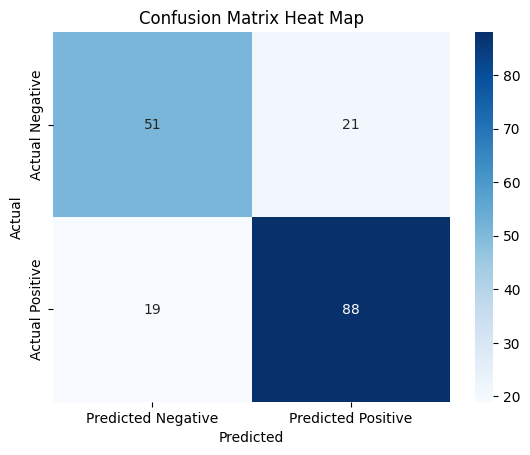

In [213]:
print('Logistic_regression:')
precision_logreg,recall_logreg,f1_logreg,accuracy_logreg,auc_logreg,fpr_logreg,tpr_logreg = classification_metrics(y_test,y_pred_logreg_cv,y_proba_logreg)

### K-Nearest Neighbours

In [214]:
param = {"n_neighbors": np.arange(1, 35)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid= param,cv=10, scoring='precision', n_jobs=-1, verbose=1)
knn_cv.fit(X_train_scaled,y_train.values.ravel())
knn_cv.best_params_

Fitting 10 folds for each of 34 candidates, totalling 340 fits


{'n_neighbors': 4}

              precision    recall  f1-score   support

           0       0.61      0.79      0.69        72
           1       0.82      0.65      0.73       107

    accuracy                           0.71       179
   macro avg       0.71      0.72      0.71       179
weighted avg       0.74      0.71      0.71       179

High Traffic Precision:  0.8235294117647058
High Traffic Recall:  0.6542056074766355
High Traffic F1_score:  0.7291666666666666
Accuracy:  0.7094972067039106
Area under the Curve: 0.7964044652128764
Confusion_Matrix:


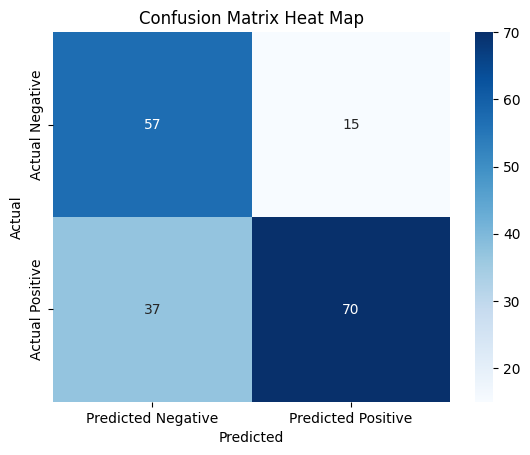

In [215]:
knn_best = KNeighborsClassifier(n_neighbors=4)
knn_best.fit(X_train_scaled,y_train.values.ravel())
y_pred_knn = knn_best.predict(X_test_scaled)
y_proba_knn= knn_best.predict_proba(X_test_scaled)[:, 1]
precision_knn,recall_knn,f1_knn,accuracy_knn,auc_knn,fpr_knn,tpr_knn = classification_metrics(y_test,y_pred_knn,y_proba_knn)

### Random Forest

In [216]:
#randomforest
rf_clf = RandomForestClassifier(random_state=2024)
param_rf = {
     'n_estimators': randint(100, 500),
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_leaf': randint(1, 30),
}
cv_rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_rf, 
                                   n_iter=100, cv=10, scoring='precision', 
                                   random_state=2024, n_jobs=-1, verbose=1)
cv_rf.fit(X_train_scaled,y_train.values.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2024),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 10, 20, 30, 40],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028ABDD740B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028AB5EE7740>},
                   random_state=2024, scoring='precision', verbose=1)

In [217]:
cv_rf.best_params_

{'max_depth': 30, 'min_samples_leaf': 6, 'n_estimators': 452}

In [218]:
rf_best_model = cv_rf.best_estimator_

              precision    recall  f1-score   support

           0       0.71      0.51      0.60        72
           1       0.72      0.86      0.79       107

    accuracy                           0.72       179
   macro avg       0.72      0.69      0.69       179
weighted avg       0.72      0.72      0.71       179

High Traffic Precision:  0.7244094488188977
High Traffic Recall:  0.8598130841121495
High Traffic F1_score:  0.7863247863247863
Accuracy:  0.7206703910614525
Area under the Curve: 0.8352803738317757
Confusion_Matrix:


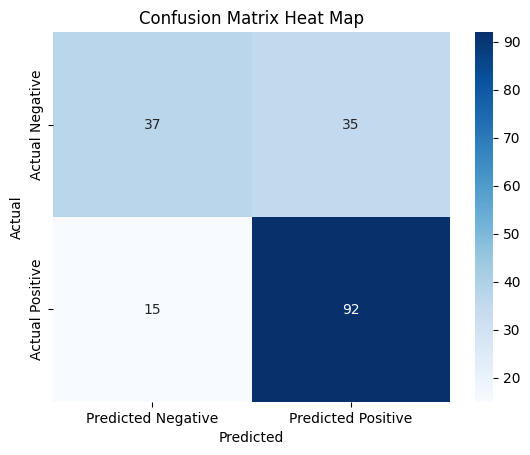

In [219]:
y_pred_rf = rf_best_model.predict(X_test_scaled)
y_proba_rf = rf_best_model.predict_proba(X_test_scaled)[:, 1]
precision_rf,recall_rf,f1_rf,accuracy_rf,auc_rf,fpr_rf,tpr_rf = classification_metrics(y_test,y_pred_rf,y_proba_rf)
#print('Random_Forest',classification_report(y_test,y_pred_rf))

### Decision Tree

In [220]:
dt_clf = DecisionTreeClassifier(random_state= 2024)
param_dt = { 
    'max_depth': randint(2,20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 30)
}
cv_dt = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_dt, 
                                   n_iter=100, cv=10, scoring='precision', 
                                   random_state=2024, n_jobs=-1, verbose=1)
cv_dt.fit(X_train_scaled,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=2024),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028ABE00CBF0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028ABE1469C0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028ABE147740>},
                   random_state=2024, scoring='precision', verbose=1)

In [221]:
cv_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 2}

In [222]:
cv_dt.best_score_

0.8014838926347878

Model_Evaluation_Decision_tree:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        72
           1       0.81      0.82      0.82       107

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

High Traffic Precision:  0.8148148148148148
High Traffic Recall:  0.822429906542056
High Traffic F1_score:  0.8186046511627907
Accuracy:  0.7821229050279329
Area under the Curve: 0.7873831775700935
Confusion_Matrix:


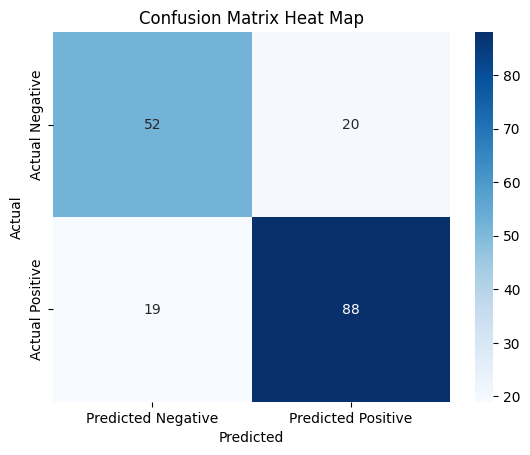

In [223]:
dt_best_model = cv_dt.best_estimator_
y_pred_dt = dt_best_model.predict(X_test_scaled)
y_proba_dt = dt_best_model.predict_proba(X_test_scaled)[:, 1]
print('Model_Evaluation_Decision_tree:')
precision_dt,recall_dt,f1_dt,accuracy_dt,auc_dt,fpr_dt,tpr_dt = classification_metrics(y_test,y_pred_dt,y_proba_dt)




In [224]:
#dt_y_proba = dt_best_model.predict_proba(X_test_scaled)[:, 1]
#dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_proba)
#dt_auc = roc_auc_score(y_test, dt_y_proba)

### Model Evaluation

In [225]:
df_model_comparision = pd.DataFrame(
    {
        'Precision' : [precision_logreg,precision_knn,precision_rf,precision_dt],
    'Recall':[recall_logreg,recall_knn,recall_rf,recall_dt],
    'F1_score' : [f1_logreg,f1_knn,f1_rf,f1_dt],
    'Accuracy' : [accuracy_logreg,accuracy_knn,accuracy_rf,accuracy_dt],
    'AUC':[auc_logreg,auc_knn,auc_rf,auc_dt],
    'Model':['LogisticReg','Knn','RandomForest','DecisionTree']
    },
    index = ['LogisticReg','Knn','RandomForest','DecisionTree']
)

In [226]:
df_model_comparision

,Precision,Recall,F1_score,Accuracy,AUC,Model
LogisticReg,0.807339,0.822430,0.814815,0.776536,0.846443,LogisticReg
Knn,0.823529,0.654206,0.729167,0.709497,0.796404,Knn
RandomForest,0.724409,0.859813,0.786325,0.720670,0.835280,RandomForest
DecisionTree,0.814815,0.822430,0.818605,0.782123,0.787383,DecisionTree


In [227]:
np.round(df_model_comparision,2)

,Precision,Recall,F1_score,Accuracy,AUC,Model
LogisticReg,0.81,0.82,0.81,0.78,0.85,LogisticReg
Knn,0.82,0.65,0.73,0.71,0.80,Knn
RandomForest,0.72,0.86,0.79,0.72,0.84,RandomForest
DecisionTree,0.81,0.82,0.82,0.78,0.79,DecisionTree


In [228]:
df_model_comparision_graph = df_model_comparision.drop(columns=['Accuracy','Precision','Recall'])

Our goal is to identify the best Model to Correctly predict high traffic recipes 80% of the time.

We are having High Traffic Prediction Metric which we can use to compare the performance of different model.
Precision: Measures how many of the predicted high traffic recipes are actually high traffic.
Recall: Measures how many of the actual high traffic recipes are correctly predicted.
So balancing these two metrics we can take F1 score as on of the metric.
AUC: Measures the model's ability to distinguish between high and low traffic recipes across different threshold which comfirms the models ability to predict high traffic receipes at all times.

High Traffic Prediction Metric can be defined as combination of F1_score and AUC.


In [229]:
met = df_model_comparision_graph.melt(id_vars = 'Model')

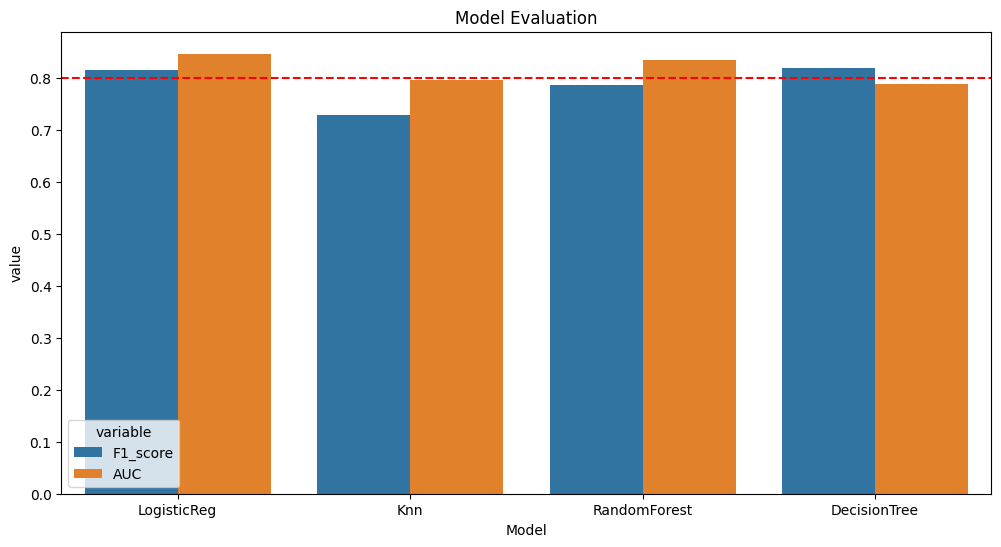

In [230]:
plt.figure(figsize=(12, 6))
sns.barplot(data = met , x = 'Model', y = 'value',hue = 'variable' )
plt.title('Model Evaluation')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.show()

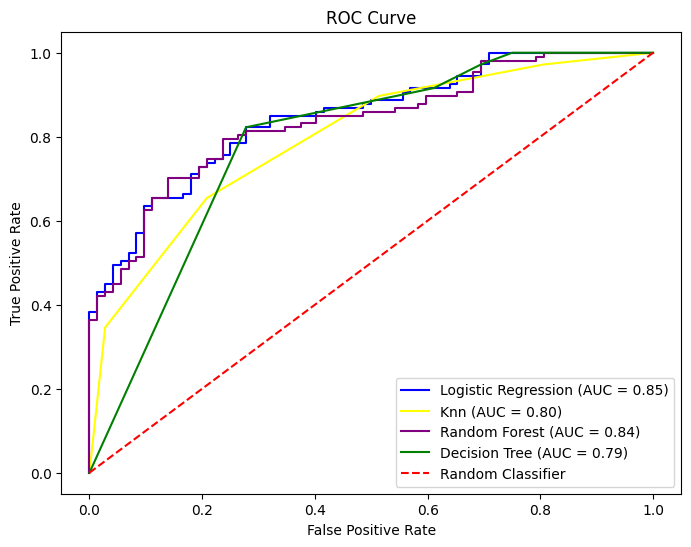

In [231]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_knn, tpr_knn, color='yellow', label=f'Knn (AUC = {auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='purple', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Precision for High Traffic (Class 1):

Logistic Regression: 0.80 (80%)
Decision Tree: 0.81 (81%)
Both models meet the primary criterion of having a precision of at least 80% for high traffic recipes. However, the precision difference is minimal and slightly in favor of the Decision Tree.

ROC AUC Score:

Logistic Regression: 0.85
Decision Tree: 0.79
The ROC AUC score for Logistic Regression is significantly higher, indicating that it has a better overall ability to distinguish between high and low traffic recipes across different thresholds.

KPI
Precision: Both models have a precision around 80%, which means that when they predict a recipe will lead to high traffic, they are correct 80% of the time.
ROC AUC: The ROC AUC score of 0.85 for Logistic Regression implies that it is better at separating high traffic recipes from low traffic ones, reducing the chances of false positives (predicting high traffic when it's actually low).    

High Precision: Ensuring that 80% of the recipes predicted as high traffic indeed generate high traffic means fewer false alarms and more accurate targeting. Logistic Regression achieves this precision.

Higher ROC AUC: A higher AUC score of 0.85 means that Logistic Regression is more robust across different decision thresholds. This ensures that the model maintains high precision and recall, providing consistent high traffic prediction performance over time.

Balancing False Positives and Negatives: Logistic Regression's higher AUC indicates better management of false positives (predicting high traffic incorrectly) and false negatives (missing actual high traffic recipes), which is essential for maintaining reliable high traffic predictions.

Consistent High Precision: Logistic Regression ensures that 80% of the time, the recipes predicted as high traffic are indeed high traffic, meeting the critical precision requirement.
Superior Discrimination Ability: With an ROC AUC score of 0.85, Logistic Regression excels at distinguishing between high and low traffic recipes, offering more reliable and accurate predictions over time.
Balanced Error Management: The higher AUC also suggests that Logistic Regression effectively balances false positives and false negatives, which is crucial for maintaining the quality of predictions and overall user satisfaction.

Business Metrics:
F1 Score: Balances precision and recall, providing a single metric that considers both false positives and false negatives. A higher F1 score indicates better performance in both precision and recall.
AUC (Area Under the Curve): Measures the model's ability to distinguish between classes in different thersholds. A higher AUC indicates better performance.

KNN has the lowest AUC and F1 score, indicating it is the least effective model in distinguishing between high and low traffic recipes and balancing precision and recall.
While Random Forest performs well, its AUC is slightly lower than Logistic Regression, and its F1 score is also lower. Logistic Regression outperforms it in both key metrics.
Although Decision Tree has the highest F1 score, its AUC is significantly lower than Logistic Regression. The AUC is crucial as it measures the overall performance of the model in distinguishing between classes. Therefore, the lower AUC makes it less preferable compared to Logistic Regression.

Best Model -  Logistic Regression:
AUC: 0.846443 (Highest among all models)
F1 Score: 0.814815 (Second highest, very close to Decision Tree)
Logistic Regression has the highest AUC, indicating it has the best ability to distinguish between high and low traffic recipes. The F1 score is also very high, indicating a good balance between precision and recall.In other words,Logistic Regression's higher AUC indicates better management of false positives (predicting high traffic incorrectly) and false negatives (missing actual high traffic recipes), which is essential for maintaining reliable high traffic predictions. Therefore, Logistic Regression is the best choice as it excels in both key metrics.


### Recommendations:

Based on the evaluation of multiple models, I recommend implementing the Logistic Regression model for predicting high traffic recipes. The analysis shows that Logistic Regression outperforms other models in key metrics, making it the most suitable choice for this task.

1.Regular Monitoring: Continuously monitor the model's performance using AUC, F1 score.
2.Fine-Tuning: Periodically fine-tune the model with updated data to maintain its predictive accuracy and reliability.
3.Suggest recording additional metrics like the number of times recipes are ordered and the time of year to identify seasonality and enhance the model's ability to predict high-traffic recipes.



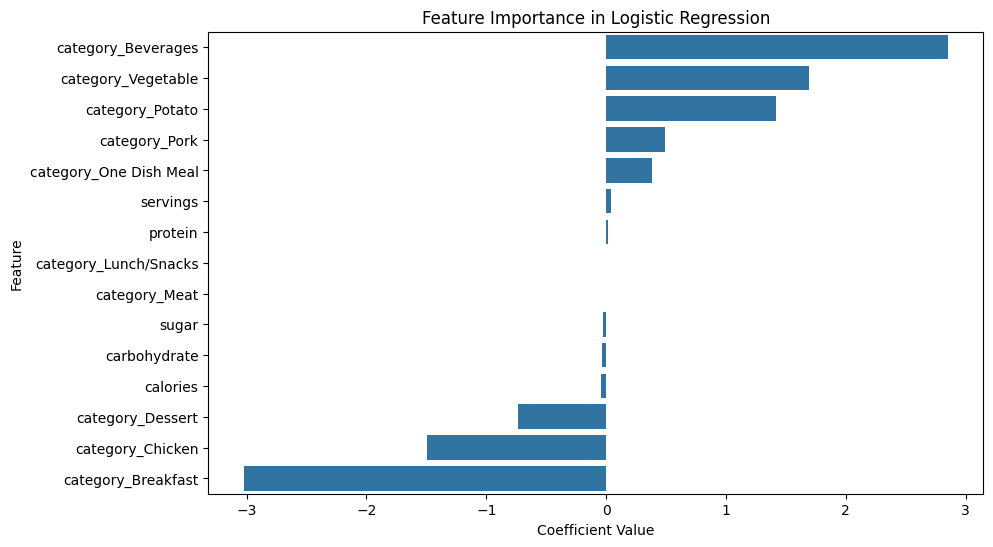

In [234]:
coefficients = logreg_best_model.coef_[0]
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

AUC (Area Under the Curve):

Logistic Regression AUC: 0.846443 (Highest)
Significance: A higher AUC indicates better performance in distinguishing between high and low traffic recipes across different thresholds. This means Logistic Regression is more reliable in predicting high traffic recipes accurately.
F1 Score:

Logistic Regression F1 Score: 0.814815 (Very High)
Significance: The F1 score balances precision and recall, providing a comprehensive measure of the model's accuracy in predicting high traffic recipes while minimizing false positives and false negatives.
Precision and Recall:

Precision: 0.807339
Recall: 0.822430
Significance: High precision ensures that a high percentage of predicted high traffic recipes are indeed high traffic. High recall ensures that most of the actual high traffic recipes are correctly predicted.